# Шаг 1. Загрузка данных

1.1 Загрузите данные. Файлы `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv` доступны по ссылкам в описании данных или через пути к ним:

- `/datasets/market_file.csv`
- `/datasets/market_money.csv`
- `/datasets/market_time.csv`
- `/datasets/money.csv`

Обратите внимание: в некоторых файлах разделитель значений — точка с запятой, а разделитель десятичных значений — запятая.

1.2 Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.

In [4]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install shap -q

In [5]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import sklearn
import shap
import seaborn as sns

from pandas.plotting import scatter_matrix
from functools import reduce
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score


warnings.filterwarnings('ignore')

In [6]:
print(f'Версия sklearn: {sklearn.__version__}')
print(f'Версия pd: {pd.__version__}')

Версия sklearn: 1.1.3
Версия pd: 1.2.4


### *Объявляем константы*

In [7]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [8]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
display(market_file.info())
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [9]:
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
display(market_money.info())
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
display(market_time.info())
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', delimiter=';', decimal=',')
display(money.info())
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Выводы по шагу 1. 

1. Файлы `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv` загружены и сохранены.
2. В файле `money.csv` в качестве разграничителя использовалась точка с запятой. Десятичный разделитель переведен в формат точки.
3. В таблице `market_file` 1300 строк без пропусков, встречаются ошибки написания (напр., "стандартт").
4. В таблице `market_money` 3900 строк без пропусков, встречаются ошибки написания (напр., "препредыдущий_месяц").
5. В таблице `market_time` 2600 строк без пропусков, встречаются ошибки написания (напр., "предыдцщий_месяц").
6. В таблице `money` 1300 строк без пропусков.

# Шаг 2. Предобработка данных

*Запишем столбец `минут` в таблице `market_time` с большой буквы для унификации названий столбцов*

In [12]:
market_time = market_time.rename(columns={'минут' : 'Минут'})
market_time.head()

,id,Период,Минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


#### Обработка пропусков

In [13]:
#функция поиска пропусков, где df – название таблицы

def data_abscence(df):
    name = [x for x in globals() if globals()[x] is df][0]
    if df.isna().sum().any() >= 1:
        print(f'В таблице {name} обнаружены пропуски, вот они:')
        display(df[df.isna() == 1])
    else:
        print(f'Пропусков в таблице {name} не обнаружено!')

In [14]:
data_abscence(market_file)
data_abscence(market_money)
data_abscence(market_time)
data_abscence(money)

Пропусков в таблице market_file не обнаружено!
Пропусков в таблице market_money не обнаружено!
Пропусков в таблице market_time не обнаружено!
Пропусков в таблице money не обнаружено!


In [15]:
#функция определения явных дубликатов в таблицах, где df – название таблицы

def duplicates(df):
    name = [x for x in globals() if globals()[x] is df][0]
    if df.duplicated().any() > 0:
        print(f'Обнаружены дубликаты в таблице {name} вот они:')
        display(df[df.duplicated(keep=False) == 1])
    else:
        print(f'Явных дубликатов в таблице {name} не обнаружено!')

In [16]:
duplicates(market_file)
duplicates(market_money)
duplicates(market_time)
duplicates(money)

Явных дубликатов в таблице market_file не обнаружено!
Явных дубликатов в таблице market_money не обнаружено!
Явных дубликатов в таблице market_time не обнаружено!
Явных дубликатов в таблице money не обнаружено!


Определим неявные дубликаты по столбцам каждой таблицы

In [17]:
def unique(df, columns):
    name = [x for x in globals() if globals()[x] is df][0]
    print('\033[1m' + f'Уникальные значения таблицы {name}:' + '\033[0m')
    print('')
    for column in list(columns):
        unique_values = df[column].unique()
        print(f'Столбец `{column}` : {unique_values}')
    print('')

In [18]:
unique(market_file, market_file.select_dtypes(exclude='number').columns)
unique(market_money, market_money.select_dtypes(exclude='number').columns)
unique(market_time, market_time.select_dtypes(exclude='number').columns)

Уникальные значения таблицы market_file:

Столбец `Покупательская активность` : ['Снизилась' 'Прежний уровень']
Столбец `Тип сервиса` : ['премиум' 'стандартт' 'стандарт']
Столбец `Разрешить сообщать` : ['да' 'нет']
Столбец `Популярная_категория` : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Уникальные значения таблицы market_money:

Столбец `Период` : ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Уникальные значения таблицы market_time:

Столбец `Период` : ['текущий_месяц' 'предыдцщий_месяц']



*Уберем пробелы в столбце `Популярная_категория`*

In [19]:
market_file['Популярная_категория'] = market_file['Популярная_категория'].replace(' ', '_', regex=True)
market_file['Популярная_категория'].unique()

array(['Товары_для_детей', 'Домашний_текстиль', 'Косметика_и_аксесуары',
       'Техника_для_красоты_и_здоровья', 'Кухонная_посуда',
       'Мелкая_бытовая_техника_и_электроника'], dtype=object)

*Скорее всего, 'препредыдущий_месяц' в таблице market_money не является неявным дубликатом и обозначает позапрошлый месяц.*

In [20]:
market_file = market_file.replace(['стандартт'], ['стандарт'])
market_time = market_time.replace(['предыдцщий_месяц'], ['предыдущий_месяц'])

*Проверим дубликаты id*

In [21]:
print(f'Количество дубликатов id в датасете: {market_file["id"].duplicated().sum()}')

Количество дубликатов id в датасете: 0


In [22]:
duplicates(market_file)
duplicates(market_money)
duplicates(market_time)

Явных дубликатов в таблице market_file не обнаружено!
Явных дубликатов в таблице market_money не обнаружено!
Явных дубликатов в таблице market_time не обнаружено!


#### Выводы по шагу 2. 

1. Проведен поиск пропусков в таблицах – пропусков не обнаружено.
2. Проведен поиск явных дубликатов в таблицах - явных дубликатов не обнаружено.
3. Проведен поиск неявных дубликатов и некорректных значений:
   1. В таблице `market_file` проведена замена значения `стандартт` на `стандарт`
   2. В таблице `market_time` – `предыдцщий_месяц` на `предыдущий_месяц`

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️ <br>
<font color='green'>Здорово, что не забываешь про промежуточные выводы.</font>

# Шаг 3. Исследовательский анализ данных

**Задача:**

* Проведите исследовательский анализ данных из каждой таблицы.
* Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
* Оформите выводы по результатам шага

In [23]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [24]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [25]:
market_time.describe()

,id,Минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [26]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [27]:
#функция создания гистограмм распределения, где df - название датафрейма

def hist(df):
    name = [x for x in globals() if globals()[x] is df][0]
    df = df.drop('id', axis=1, errors='ignore')
    num_col = list(df.select_dtypes(include='number').columns)
    #df_num = pd.DataFrame(num_col)
    #print(len(num_col))
    x = []
    if len(num_col) <= 1:
        #fig, ax = plt.subplots(1, 1, figsize=(3*len(num_col), 3))
        df[num_col].hist()
        plt.axvline(df[num_col].mean()[0],  color='r', linewidth=2)
        plt.axvline(df[num_col].median()[0], color='orange', linestyle='--', linewidth=2)
        plt.text(df[num_col].mean()[0], 0.99, 'mean', color='r', ha='left', va='bottom', rotation=90)
        plt.text(df[num_col].median()[0], 0.99, 'median', color='orange', ha='right', va='top', rotation=90)
        plt.title(num_col)
        plt.suptitle(f'Диаграмма распределения числовых показателей датафрейма {name}', y=1.0)
    else:
        fig, ax = plt.subplots(1, len(num_col), figsize=(3*len(num_col), 3))
        for i, col in enumerate(df[num_col]):
            df[col].hist(ax=ax[i])
            ax[i].axvline(df[col].mean(),  color='r', linewidth=2)
            ax[i].axvline(df[col].median(), color='orange', linestyle='--', linewidth=2)
            ax[i].text(df[col].mean(), 0.99, 'mean', color='r', ha='left', va='bottom', rotation=90)
            ax[i].text(df[col].median(), 0.99, 'median', color='orange', ha='right', va='top', rotation=90)
            ax[i].set_title(col, rotation=7)
    
        plt.suptitle(f'Диаграмма распределения числовых показателей датафрейма {name}', y=1.2)
    plt.show()

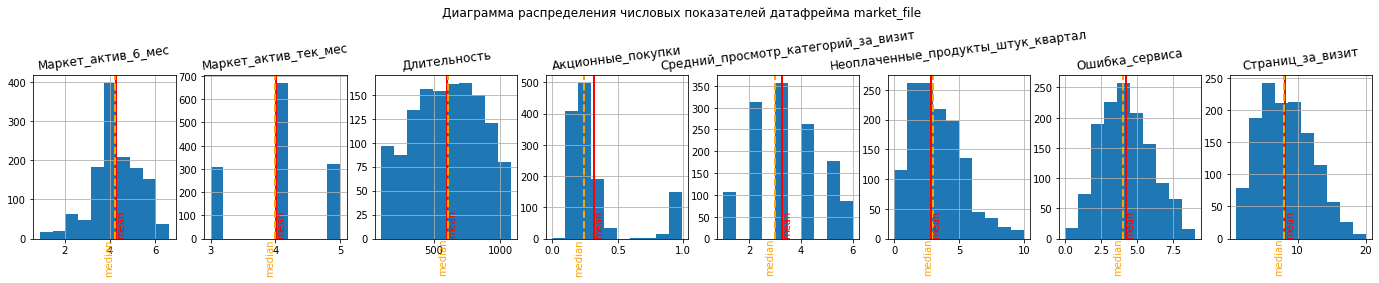

In [28]:
hist(market_file)

*По столбцу `Акционные покупки` видно, что часть пользователей покупает, преимущественно, по акциям. Выведем их количество*

In [29]:
print(f'Число пользователей, покупающих большинство товаров по акции: {market_file[market_file["Акционные_покупки"] >= 0.7].shape[0]}')

Число пользователей, покупающих большинство товаров по акции: 167


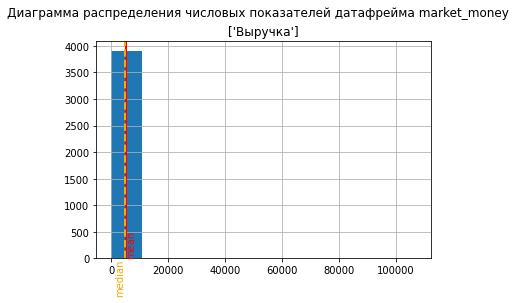

In [30]:
hist(market_money)

*Отмечается явный выброс в районе 100000 руб. Посмотрим, от скольких пользователей выручка превышает 10000 руб.*

In [31]:
market_money[market_money['Выручка'] > 10000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


*Пользователь с id 215380 в текущем месяце приобрел товара на 106862 руб. Это явный  и очень сильный выброс, который может помешать машинному обучению. Посмотрим на срез данных из таблицы `market_money`*

In [32]:
market_money[95:100]

,id,Период,Выручка
95,215379,текущий_месяц,4394.9
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2
99,215381,препредыдущий_месяц,4503.0


*Удалять данного пользователя не стоит, т.к. у него были покупки за 2 предыдущих месяца. Заменим его выручку на медианное значение выручки в таблице*

In [33]:
market_money = market_money.replace([106862.2],  market_money.loc[97, 'Выручка'])
market_money[95:100]

,id,Период,Выручка
95,215379,текущий_месяц,4394.9
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,6077.0
99,215381,препредыдущий_месяц,4503.0


*Оценим повторно распределение данных в таблице `market_money`*

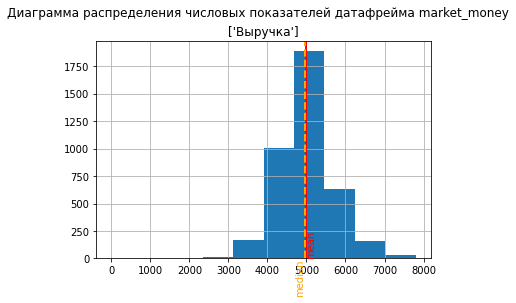

In [34]:
hist(market_money)

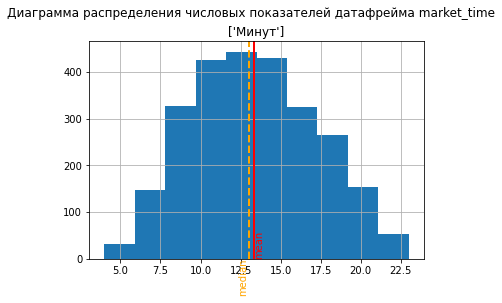

In [35]:
hist(market_time)

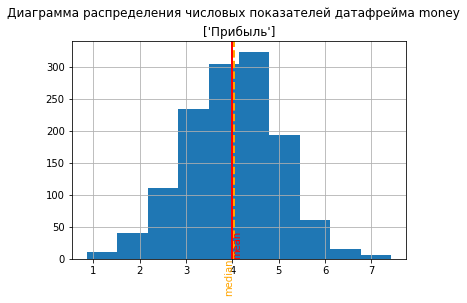

In [36]:
hist(money)

*Посмотрим распределение выручки по периодам*

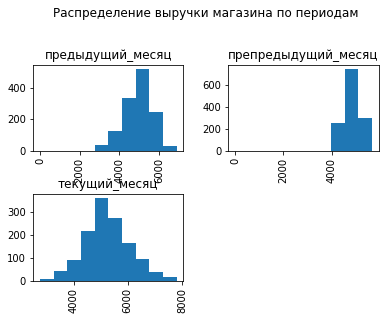

In [37]:
market_money.hist('Выручка', by='Период')
plt.suptitle('Распределение выручки магазина по периодам', y=1.1)
plt.show()

*Посмотрим показатели выручки пользователей по месяцам*

In [38]:
market_money_pivot = pd.pivot_table(market_money, values='Выручка', index=['Период'], aggfunc=('median', 'mean', 'min'))
market_money_pivot

,mean,median,min
Период,,,
предыдущий_месяц,4936.920385,5005.00,0.0
препредыдущий_месяц,4825.206923,4809.00,0.0
текущий_месяц,5237.433769,5179.95,2758.7


*Проверим распределение времени на сайте по периодам*

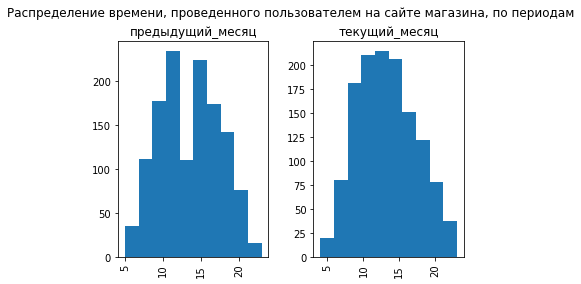

In [39]:
market_time.hist('Минут', by='Период')
plt.suptitle('Распределение времени, проведенного пользователем на сайте магазина, по периодам', y=1.02)
plt.show()

*Посмотрим показатели времени на сайте по месяцам*

In [40]:
market_time_pivot = pd.pivot_table(market_time, values='Минут', index=['Период'], aggfunc=('median', 'mean', 'min'))
market_time_pivot

,mean,median,min
Период,,,
предыдущий_месяц,13.467692,13.0,5.0
текущий_месяц,13.204615,13.0,4.0


*Отберем пациентов с покупательской активностью за последние 3 мес. и посмотрим визуализацию данных по ним*

In [41]:
market_money_pivot = pd.pivot_table(market_money, values='Выручка', index=['id'], aggfunc='sum')
print(f'Количество дубликатов в таблице market_money_pivot : {market_money_pivot.index.duplicated().sum()}')
print(f'Количество пользователей в таблице market_money_pivot : {market_money_pivot.shape[0]}')

Количество дубликатов в таблице market_money_pivot : 0
Количество пользователей в таблице market_money_pivot : 1300


*Удалим из таблицы тех покупателей, кто не совершил какой-либо покупки за один из трех прошлых месяцев*

In [42]:
market_money_active = pd.pivot_table(market_money, values='Выручка', index='id', columns='Период', aggfunc='sum')
market_money_active['id'] = market_money_active.index
market_money_active = market_money_active.reset_index(drop=True)
market_money_active.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,id
0,0.0,0.0,3293.1,215348
1,5216.0,4472.0,4971.6,215349
2,5457.5,4826.0,5058.4,215350
3,6158.0,4793.0,6610.4,215351
4,5807.5,4594.0,5872.5,215352


In [43]:
inactive_ids = list(market_money_active[(market_money_active['предыдущий_месяц'] == 0) |
                                  (market_money_active['препредыдущий_месяц'] == 0) |
                                  (market_money_active['текущий_месяц'] == 0)]['id'])
inactive_ids

[215348, 215357, 215359]

*Таким образом, всего 3 покупателя, представленные в таблице `market_money`, не делали покупое за какой-либо из последних 3 месяцев. Удалим этих пользователей из объединенной таблицы*

*Посмотрим на распределение качественных данных*

In [44]:
#функция построения круговых диаграмм, где df – датафрейм

def cat_visual(df):
    cat_cols = list(df.select_dtypes(exclude='number').columns)
    fig, ax = plt.subplots(1, len(cat_cols), figsize=(3*len(cat_cols), 5))
    for i, col in enumerate(df[cat_cols]):
        label = list(df[col].value_counts().index)
        ax[i].pie(df[col].value_counts(), labels=label, autopct='%1.1f%%')
        ax[i].set_title(str(col))

*Укажем столбцы с качественными данными*

In [45]:
cat_cols = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

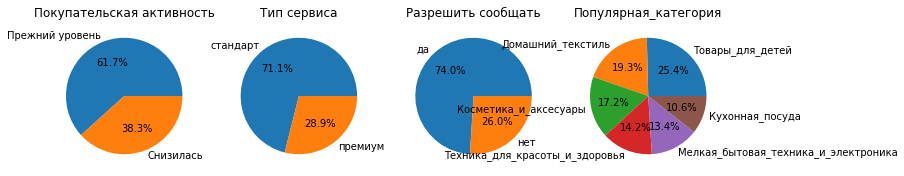

In [46]:
cat_visual(market_file)

#### Выводы по шагу 3.

Таблица `market_file`:
1. Отмечается распредление, близкое к нормальному, по маркет_активу за последние 6 мес. и за текущий мес. Среднее количество маркетинговых контактов - 4 в месяц.
2. Средняя длительность регистрации пользователя на сайте – 606 суток ± 249 дней. Распределение, близкое к нормальному.
3. У большей части пользователей акционные покупки занимают меньшую часть покупок (медиана - 24%), однако 167 пользователей приобретает товары, в основном, по акциям (с долей покупок по акции ≥70%). Распределение ассиметричное, с двумя пиками.
4. За 1 визит пользователь, в среднем, просматривает 3 категории товаров. Значит, большинство пользователей заходит на сайт с целью сделать несколько покупок. Распределение, близкое к нормальному.
5. В среднем, за квартал пользователь не оплачивает 3 товара. Распределение ассиметричное, со смещением вправо.
6. За время посещения сайта пользователь сталкивается, в среднем, с 4 ошибками сайта. **Здесь видится неточность описания признака. Если проводился подсчет количества ошибок за 1 посещение, то это очень много. Тогда следует с помощью ИТ-специалистов снизить число ошибок. Если подсчет велся за все время посещений, то средняя цифра в 4 ошибки представляется небольшой.** Распределение, близкое к нормальному.
7. В среднем, пользователь посещает 8 страниц за визит. Распределение, ожидаемо, со смещением вправо из-за того, что меньшая часть пользователей просматривает больше страниц за 1 посещение.
8. У 38,3% покупателей за последние 3 мес. снизилась покупательская активность.
9. Более 2/3 покупаталей пользуются тарифом "стандарт".
10. Большинство покупателей (74%) соглашаются на маркетинговые рассылки.
11. Наиболее популярные категории товаров – "Товары для детей" (25,4%), "Домашний текстиль" (19,3%), наименее популярные – "Кухонная посуда" (10,6%) И "Мелкая бытовая техника и электроника" (13,4%).

Таблица `market_money`:
1. Почти все пользователи совершили покупки за последние 3 мес (абсолютно все – в текущем месяце), кроме трех покупателей.
2. За последний (текущий месяц) все пользователи совершили покупки, в среднем, на сумму 5276 руб (распределение, близкое к нормальному). Возможно, это связано с увеличенной маркетинговой активностью за текущий месяц. Однако следует уточнить у заказчика, записывается ли отсутствие покупок в прошлом месяце для пользователя, который зарегистрировался только в текущем. 
3. Распределение покупок за предыдущий и позапрошлый месяц ассиметричное со сдвигом влево из-за части пользователей, которые не совершили ни одной покупки.

Таблица `market_time`:
1. В предыдущем и текущем месяце пользователи проводили, в среднем, по 13 минут на сайте. Распределение, близкое к нормальному в текущем месяце. Можно также расценить распределение в предыдущем месяце, как близкое к нормальному (т.к. пики в районе 12 и 14 минут, что может быть обычным совпадением).
2. Все пользователи проводили не менее 4-5 минут на сайте за последние 2 мес. Это означает, что все они заходили посмотреть товар, но не все из них приобрели товар в прошлом месяце. Возможно, это может быть связано с его отсутствием, более высокими ценами, сроками и стоимостью доставки.

Таблица `money`:
1. Среднее значение прибыли – 4. Распределение, близкое к нормальному.

# Шаг 4. Объединение таблиц

**Задачи:**

4.1. Объедините таблицы `market_file.csv`, `market_money.csv`, `market_time.csv`. Данные о прибыли из файла `money.csv` при моделировании вам не понадобятся. 

4.2. Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [47]:
'''
функция сводных таблиц, где:
df - датафрейм,
values - столбец в формате 'col' со значениями, над которыми будут выполнятся математические операции,
index - столбец в формате 'col' со значениями, которые отправятся в индекс сводной таблицы,
columns - столбец в формате 'col' со значениями, которые пойдут в столбец сводной таблицу,
aggfunc - функция агрегирования данных в формате 'aggfunc'
'''

def pivot(df, value, index, columns, aggfunc):
    df = pd.pivot_table(df, values=value, index=index, columns=columns, aggfunc=aggfunc)
    df = df.add_prefix(f'{value}_')
    df[index] = df.index
    df = df.reset_index(drop=True)
    return df

In [48]:
market_money_periods = pivot(market_money, 'Выручка', 'id', 'Период', 'sum')
market_money_periods.head()

Период,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,id
0,0.0,0.0,3293.1,215348
1,5216.0,4472.0,4971.6,215349
2,5457.5,4826.0,5058.4,215350
3,6158.0,4793.0,6610.4,215351
4,5807.5,4594.0,5872.5,215352


In [49]:
market_time_periods = pivot(market_time, 'Минут', 'id', 'Период', 'sum')
market_time_periods.head()

Период,Минут_предыдущий_месяц,Минут_текущий_месяц,id
0,13,14,215348
1,12,10,215349
2,8,13,215350
3,11,13,215351
4,8,11,215352


In [50]:
market = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), [market_file, market_money_periods, market_time_periods])

*Удалим из таблиц `market` и `money` пользователей без покупок в какой-либо из 3 месяцев*

In [51]:
market = market[market['id'].isin(inactive_ids) == False].reset_index(drop=True)
money = money[money['id'].isin(inactive_ids) == False].reset_index(drop=True)

display(market.tail())
print(f'Количество пустых значений `market`: {market.isna().any().sum()}')
print(f'Количество пользователей таблицы `market`: {market.shape[0]}')

display(money.tail())
print(f'Количество пользователей таблицы `money`: {money.shape[0]}')

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника_для_красоты_и_здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний_текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний_текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника_для_красоты_и_здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7
1296,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника_для_красоты_и_здоровья,4,5,3,12,4720.0,5183.0,4448.3,15,10


Количество пустых значений `market`: 0
Количество пользователей таблицы `market`: 1297


,id,Прибыль
1292,216643,4.44
1293,216644,6.11
1294,216645,3.29
1295,216646,4.03
1296,216647,3.28


Количество пользователей таблицы `money`: 1297


*После объединения таблиц создадим сводную таблицу для оценки выручки среди покупателей с разной долей акционных покупок*

In [52]:
promo = pd.DataFrame(columns=['Покупательская_активность', 'Доля_акционных_покупок', 
                              'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц'])

promo[['Покупательская_активность','Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']] = market[
['Покупательская активность','Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']]
promo['Доля_акционных_покупок'] = market['Акционные_покупки'].apply(lambda x: 'Большинство' if x>=0.7 else 'Меньшинство')
promo = pd.pivot_table(promo, values=['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц'], 
               index=['Доля_акционных_покупок'], aggfunc='mean')
promo

,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
Доля_акционных_покупок,,,
Большинство,4941.185629,4713.580838,5253.925150
Меньшинство,4949.396903,4854.514159,5236.499115


*Создадим отдельную таблицу, в которой объединим таблицу для модели `market` и таблицу с прибылью `money`*

In [53]:
market_profit = market.merge(money, on='id', how='outer')

#### Выводы по шагу 4.

1. Проведено объединение пользователей по таблицам `market_file`, `market_money_periods`, `market_time_periods` в таблицу `market`.
2. Сделаны отдельные столбцы по выручке и количеству минут, проведенных на сайте, по месяцам.
3. После объединения количество пользователей осталось прежним - 1300 чел., пустых значений после объединения не появилось.
4. Выручка среди покупателей с разной долей акционных покупок схожая за последние 3 мес. 

# Шаг 5. Корреляционный анализ

**Задача:**

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

*Сбросим столбец `id` в таблице `market` как ненужный для подсчетов*

In [54]:
market = market.drop('id', axis=1)

*Учитывая наличие ненормально распределенных данных, а также присутствие дискретных данных, корреляционный анализ проведем по методу `phik`*

*Создадим список столбцов с непрерывными данными для матрицы корреляции `phik` и напишем функцию для вывода данной матрицы*

In [55]:
interval_cols = ['Маркет_актив_6_мес', 
                 'Акционные_покупки', 
                 'Выручка_предыдущий_месяц', 
                 'Выручка_препредыдущий_месяц', 
                 'Выручка_текущий_месяц',
                ]

#функция визуализации матрицы корреляции `phik`, где df – датафрейм

def phik(df):
    phik_corr = phik_matrix(df, interval_cols=interval_cols)
    plot_correlation_matrix(phik_corr.values,
                           x_labels=phik_corr.columns,
                           y_labels=phik_corr.index,
                           vmin=0, vmax=1, color_map='Blues',
                           title=r'Матрица корреляции по методу $\phi_K$',
                           fontsize_factor=1.5,
                           figsize=(20, 15))

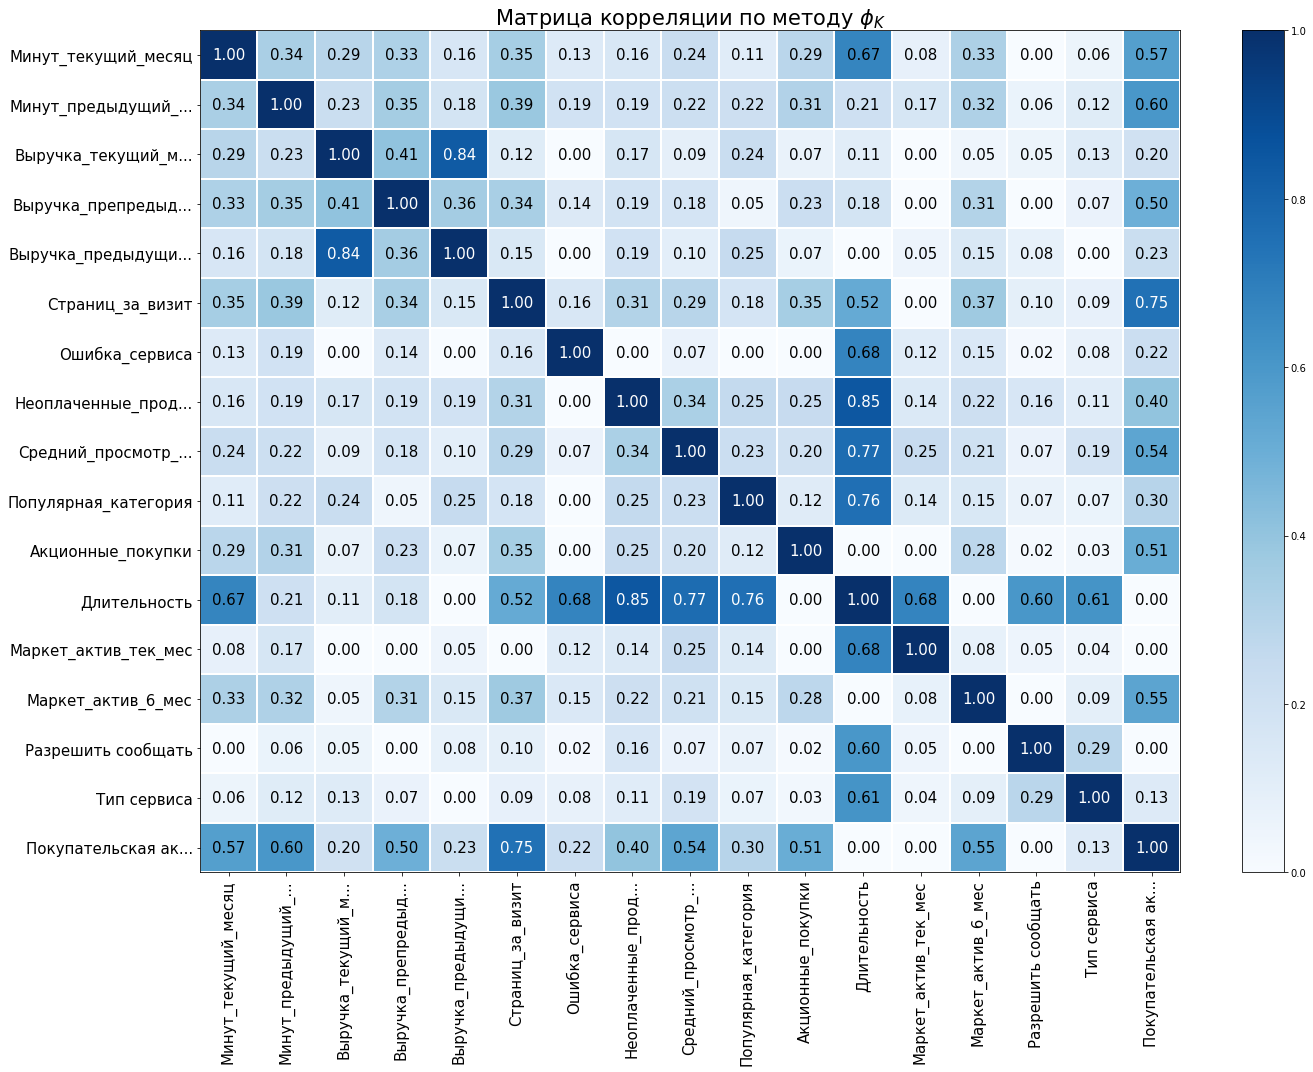

In [56]:
phik(market)

*Явной линейной зависимости между входными признаками $(φ_k≥0.9)$ не выявлено.Проверим также мультиколлинеарность по методу VIF*

#### Выводы по шагу 5

1. Обнаружена сильная корреляция (0.85) между количеством неоплаченных покупок за квартал и длительностью нахождения на сайте. Это объясняется тем, что пользователи могли добавить какие-то покупки в корзину, но продолжать искать дальше, т.к. их что-то не удовлетворяло. В конце концов, не найдя необходимого товара, они уходили с сайта, забыв выложить товар из корзины. 
2. Также выявлена сильная корреляция (0.76) между длительностью нахождения на сайте и количеством страниц за визит. Взаимосвязь очевидна и не требует комментариев.
3. Имеется сильная корреляция между количеством акционных покупок и выручкой за позапрошлый месяц (0.75). Вероятно, магазин проводил в позапрошлом месяце распродажу.
4. Выявлена положительная сильная корреляция между снижением покупательской активности и количеством страниц за визит (0.75). Очевидно, пользователь мог просмотреть множество страниц в поиске нужного товара, но не найдя такового, уходил с сайта без покупки.
5. Удаление и модификация интеркоррелирующих признаков негативно повлияла на качество моделей, поэтому признаки с мультиколлинеарностью были оставлены в датасете без изменений. 

# Шаг 6. Использование пайплайнов

Примените все изученные модели. Для этого используйте пайплайны.

6.1 Во время подготовки данных используйте `ColumnTransformer`. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

6.2 Обучите четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и `SVC()`. Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:

- использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
- использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

*Обозначим тип данных в столбцах*

In [57]:
num_cols = list(market.select_dtypes(include='number').columns)
ord_cols = ['Тип сервиса']
cat_cols = ['Разрешить сообщать', 'Популярная_категория']

*Выделим целевой признак и распределим данные на выборки для модели машинного обучения. Учитывая дисбаланс целевого класса, будем использовать стратификацию*

In [58]:
X = market.drop('Покупательская активность', axis=1)
y = market['Покупательская активность']
y = y.replace(['Снизилась', 'Прежний уровень'], [1, 0])


X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   random_state=RANDOM_STATE,
                                                   test_size=TEST_SIZE,
                                                   stratify=y)

*Пайплайн для обработки качественных данных*

In [59]:
#SimpleImputer + OHE

ohe_pipe = Pipeline([
                    (
                        'SimpleImputer_ohe',
                        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
                    ),
    (
                        'ohe',
                        OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False, categories='auto')
                    )
                   ])

*Пайплайн со вторым кодировщиком качественных данных*

In [60]:
#SimpleImputer + OrdinalEncoder

ord_pipe = Pipeline([
    (
        'SimpleImputer_before_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ord',
        OrdinalEncoder(categories='auto',
                      handle_unknown='use_encoded_value',
                      unknown_value=np.nan)
    ),
    (
        'SimpleImputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
]
                   )

*Пайплайн для обработки количественных данных*

In [61]:
#SimpleImputer + StandardScaler

num_pipe = Pipeline(
[
    (
        'SimpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'num',
        StandardScaler()
    )
])

*Пайплайн подготовки данных*

In [62]:
preprocessor_pipe = ColumnTransformer(
    [
        ('num', StandardScaler(), num_cols),
                ('ohe', ohe_pipe, cat_cols),
        ('ord', ord_pipe, ord_cols)
    ], remainder='passthrough'
)

*Финальный пайплайн* 

In [63]:
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor_pipe),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

*Cоздаем список словарей для масштабирования данных и выбора моделей*

In [64]:
param_grid = [
    # Список гиперпараметров для DecisionTreeClassifier
    {
        'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth' : range(2, 5),
        'models__max_leaf_nodes': range(2, 5),
        'models__min_samples_leaf' : range(2, 5),

        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Список гиперпараметров для KNeighborsClassifier
    {
        'models' : [KNeighborsClassifier()],
        'models__n_neighbors' : range(2, 10),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Cписок гиперпараметров для LogisticRegression
    {
        'models' : [LogisticRegression(random_state=RANDOM_STATE,
                                      solver='liblinear',
                                      penalty='l1')],
        'models__C' : range(0, 5),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Список гиперпараметров для SVM
    {
        'models' : [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel' : ['linear', 'poly', 'rbf'],
        'models__C' : range(0, 5),
        'models__gamma' : range(0, 1),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

*Запускаем подбор гиперпараметров. В качестве метрики выберем ROC-AUC, т.к. имеется дисбаланс целевого класса (см. шаг 3), а ROC-AUC устойчив к дисбалансу классов.* 

(Можно выбрать и F1-меру, т.к. характер задачи не требует принципиального перевеса в recall или precision. Возможно,  precision в виде F-beta более предпочительно, т.к. если нейросеть ошибочно посчитает, что покупательская способность снизится, то ничего страшного в том, что магазин поспешит сделать ему предложение. Но в таком случае следует оценить возможные экономические потери магазина, т.к. если нейросеть даст слишком много ложноположительных заключений, то магазин рискует потерять много денег на акционных предложениях и маркетинговых действиях)

In [65]:
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc'
)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

probs = grid.predict_proba(X_test)[:, 1]

print(f'Лучшая модель и ее параметры: \n\n {grid.best_estimator_} \n\n')
print(f'Метрика лучшей модели: {grid.best_score_} \n\n')
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probs)} \n\n')

Лучшая модель и ее параметры: 

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'Выручка_предыдущий_месяц',
                                                   'Выручка_препредыдущ...
                                       

#### Вывод по шагу 6

Лучшая модель – `KNeighborsClassifier(n_neighbors=6)`, при которой получена высокая метрика `ROC-AUC` на тренировочной выборке –  0.9, схожая с таковой на тестовой (0.91).

# Шаг 7. Анализ важности признаков

7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.

7.2 Сделайте выводы о значимости признаков:

- какие признаки мало значимы для модели;
- какие признаки сильнее всего влияют на целевой признак;
- как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

In [79]:
best_model = grid.best_estimator_[1]

X_train_preprocessed = grid.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_preprocessed = grid.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test_named = pd.DataFrame(X_test_preprocessed, columns=grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
explainer = shap.Explainer(best_model.predict, X_train_preprocessed)
shap_values = explainer(X_test_named)

PermutationExplainer explainer: 326it [04:55,  1.07it/s]                         


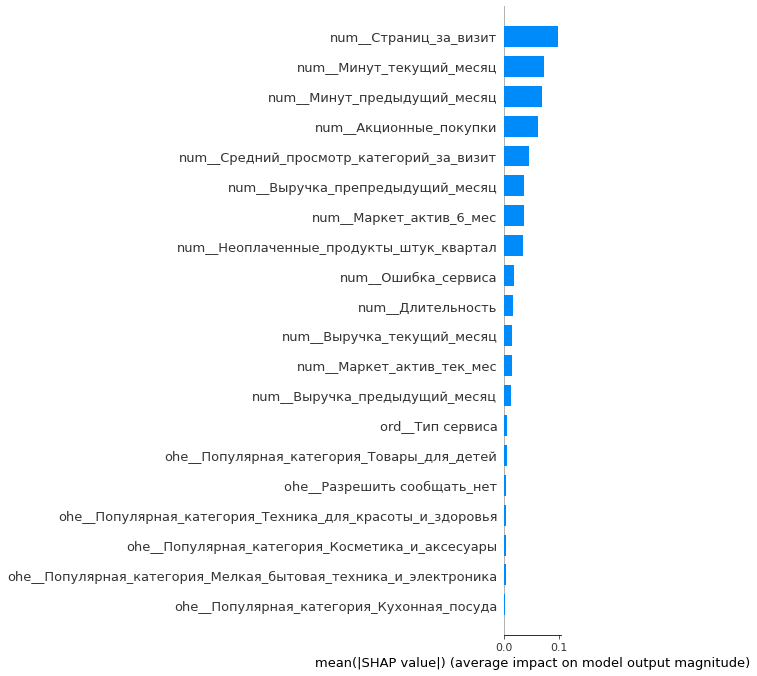

In [67]:
shap.summary_plot(shap_values, plot_type='bar', max_display=20)

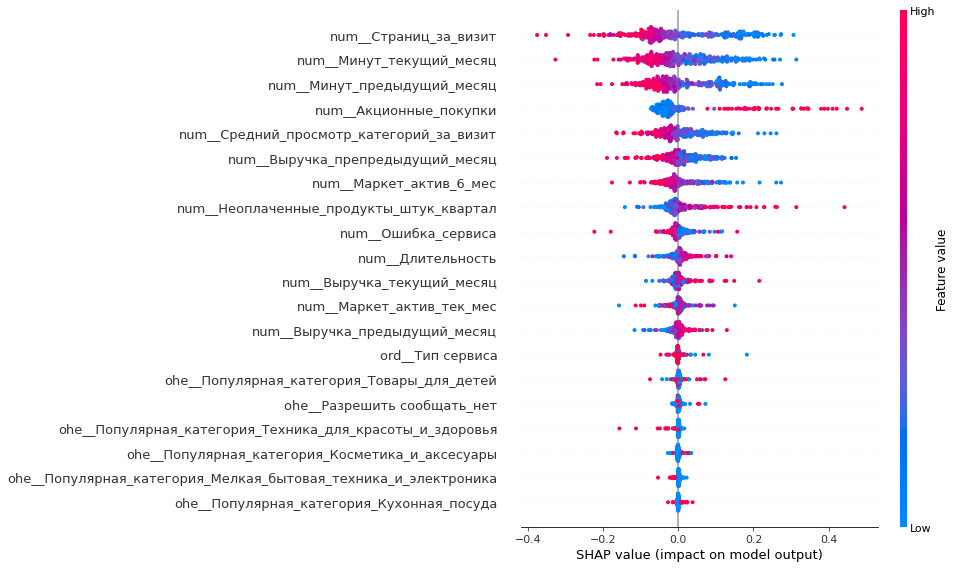

In [68]:
shap.plots.beeswarm(shap_values, max_display=20)

#### Выводы по шагу 7

1. Наименее значимые признаки для модели и возможные объяснения:
    * `Выручка_текущий_месяц`, `Выручка_предыдущий_месяц`: скорее всего, покупательская активность в магазине считается за 3 мес. и здесь более важный признак (хотя всего на 0.2 пункта выше) – `Выручка_препредыдущий_месяц`. От него уже отсчитывается, снизилась ли выручка или нет.
    * `Маркет_актив_тек_мес` – если покупательская активность рассчитывается за последние 3 мес., то маркетинговые контакты за текущий месяц могли не успеть дать эффект на точку наблюдения. Учитывая то, что `Маркет_актив_6_мес` значительно выше по важности в 4 раза, это весьма возможно; но вероятно и другое – за последние месяцы качество маркетинговых контактов могло ухудшиться и не давать больше стимулирующий к покупкам эффект. 
    * `Тип_сервиса` – вероятнее всего, премиум-сервис не дает серьезных преимуществ, которые бы стимулировали пользоваться сайтом чаще (напр., специальные скидки, бесплатная доставка, ранний доступ к распродажам, более выгодный процент по кредиту). 
    * `Разрешить_сообщать` – возможно, маркетинговые контакты за последнее время не столь эффективны. Следовательно, эффект от таких контактов такой же, как и от их отсутствия.

2. Наиболее значимые признаки для модели и возможные объяснения:
    *  `Страниц_за_визит`, `Мин_предыдущий_месяц`, `Мин_текущий_месяц` – эти категории, скорее всего, связаны друг с другом. Чем больше страниц просматривает пользователь, тем больше времени он проводит на сайте. По диаграмме пчелиного роя видно, что чем больше страниц просматривает пользователь и чем больше времени он проводит на сайте, тем больше его покупательская активность. По-видимому, данная часть пользователей приверженна сайту и старается основную часть покупок выполнять там. 
    *  `Акционные_покупки` – чем больше покупок по акции, тем меньшей была покупательская активность пользователя. Возможно, магазин давно не проводил акций, и пользователи, покупающие, в основном, по акции, ждут следующей, и за последние месяцы их покупательская активность упала. 
3. **Рекомендации для заказчика:**

Судя по распределению важности признаков, следует уделить усилия основным двум направлениям:

1. Рассмотреть возможность более частого проведения акций для пользователей с большой долей покупок по акции, т.к. они являются для них триггером покупок. Согласно таблице `promo`, выручка от таких пользователей сопоставима с теми, у кого невысокая доля покупок по акции, следовательно, у данной рекомендации есть экономическая целесообразность. 
2. Проанализировать возможные причины более длительного нахождения на сайте пользователя – провести опросы, проследить маршруты посещения, какие категории просматривали чаще (возможно, этот сайт более полезен для определенных категорий пользователей, напр., родителей с детьми), развивать систему рекомендаций (аналоги товаров, "вместе с этим товаром пользователи также покупали"). 

# Шаг 8. Сегментация покупателей

8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность:

- Проведите графическое и аналитическое исследование группы покупателей.
- Сделайте предложения по работе с сегментом для увеличения покупательской активности.

8.3 Сделайте выводы о сегментах:

- какой сегмент вы взяли для дополнительного исследования,
- какие предложения вы сделали и почему.

In [69]:
X_preprocessed = pipe_final.named_steps['preprocessor'].fit_transform(X)
market_profit['Вероятность снижения покупательской активности'] = best_model.predict_proba(X_preprocessed)[:, 1].round(2)
market_profit.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль,Вероятность снижения покупательской активности
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16,1.00
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13,0.33
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87,1.00
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21,1.00
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95,0.67


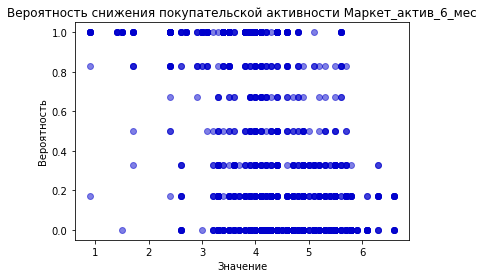

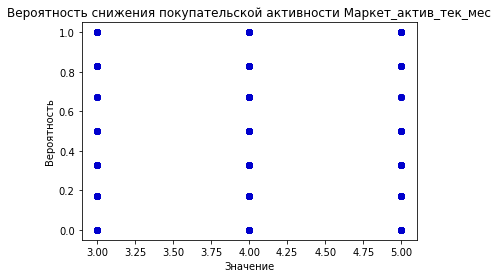

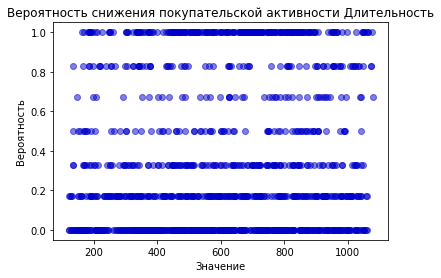

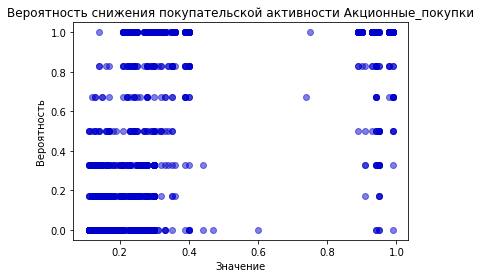

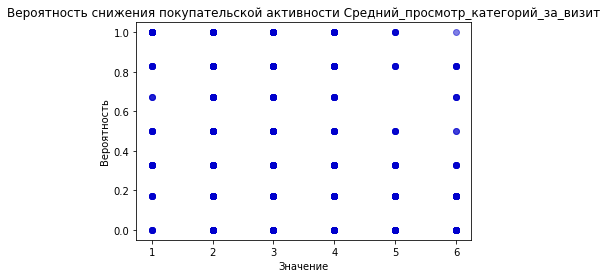

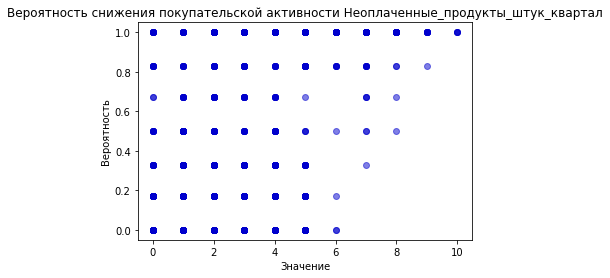

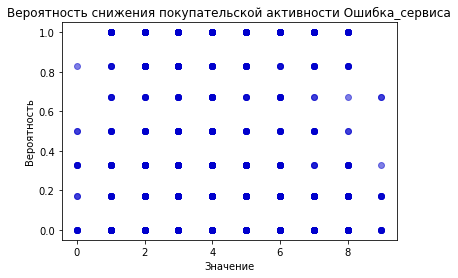

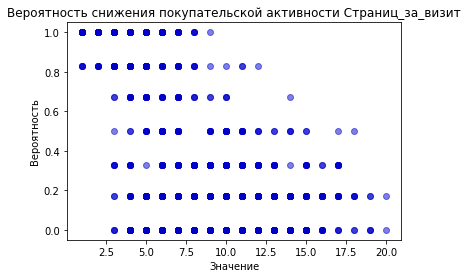

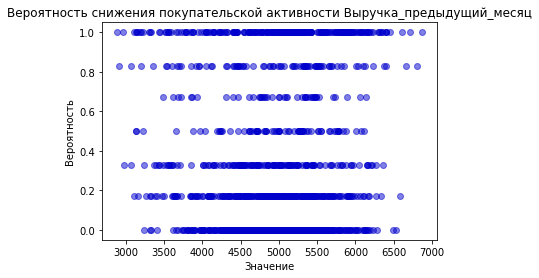

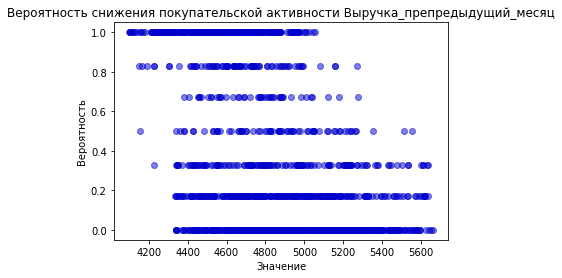

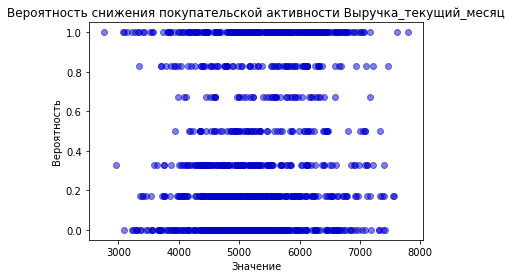

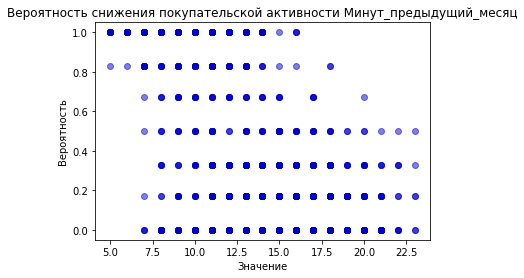

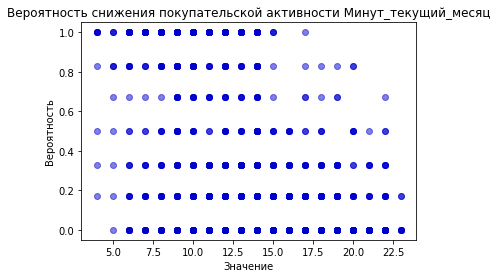

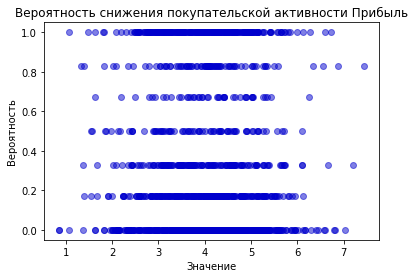

In [70]:
num_cols = list(market_profit.select_dtypes(include='number').columns)
num_cols.remove('Вероятность снижения покупательской активности')
num_cols.remove('id')

for col in num_cols:
    plt.scatter(x=market_profit[col],
               y=market_profit['Вероятность снижения покупательской активности'],
                alpha=0.5, 
               c='MediumBlue')
    plt.title(f'Вероятность снижения покупательской активности {col}')
    plt.xlabel('Значение')
    plt.ylabel('Вероятность')

    plt.show()

*Согласно матрице рассеивания, можно выделить покупателей с высокой вероятностью снижения покупательской активности по следующим категориям:*

* `Страниц_за_визит` – менее 3 страниц за визит.
* `Маркет_актив_6_мес` – менее 2 контактов за полгода.
* `Неоплаченные_покупки` – более 8 штук за квартал.
* `Выручка_предыдущий_месяц` и  `Выручка_препредыдущий_месяц`– менее 1000 руб.
* `Минут_предыдущий_месяц` – менее 7 минут.

*Посмотрим, какие у каких групп покупателей снизилась покупательская активность.*

In [71]:
# функция построения гистограммы распределения и диаграммы "ящик с усами", 
#где df – датафрейм, cols – список столбцоы датафрейма с количественными данными, by – название столбца в формате 'col' для группировки

def hist_box(df, cols, by):
    for col in cols:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x=df[col], hue=by, palette='icefire', alpha=0.5)
        plt.title(f'Признак "{col}"')
        plt.xlabel('Значение')
        plt.ylabel('Частота')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=by, y=df[col], data=df , palette='icefire')
        plt.title(f'Диаграмма "ящик с усами" для показателя "{col}"')
        plt.xlabel('Покупательская активность')
        plt.subplots_adjust(wspace=0.5)
        plt.show()

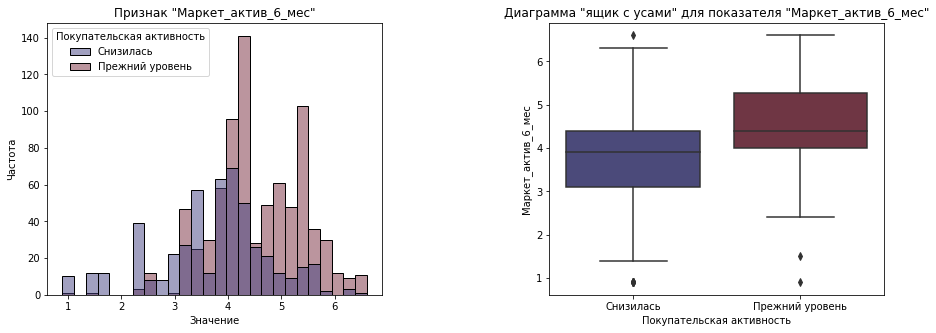

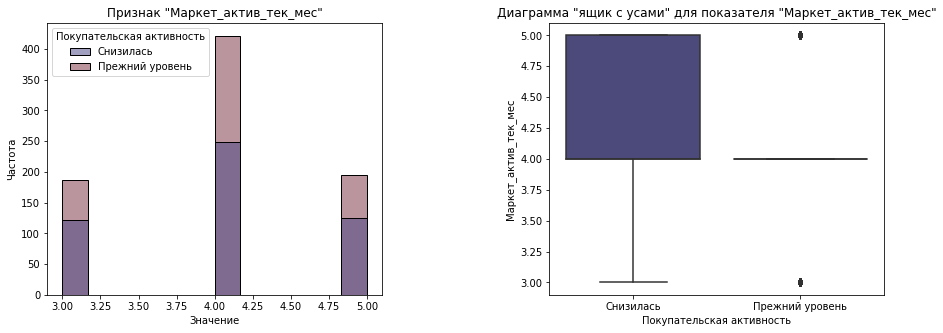

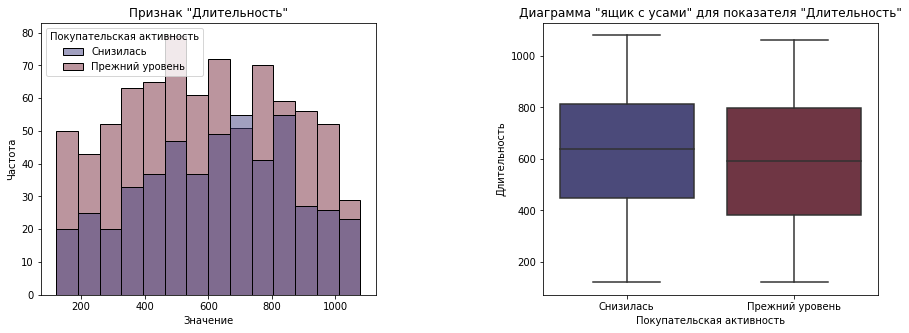

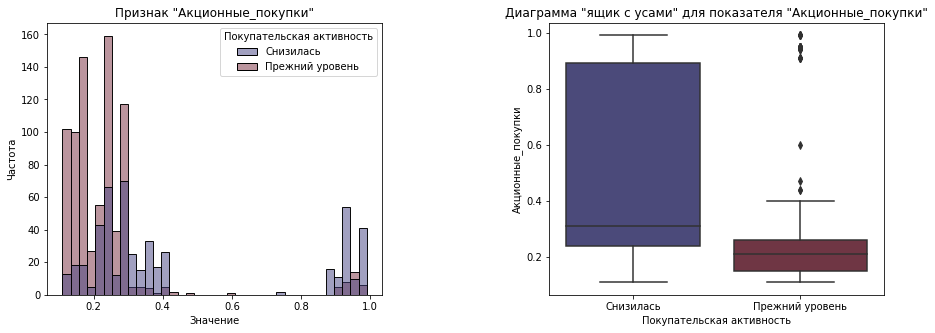

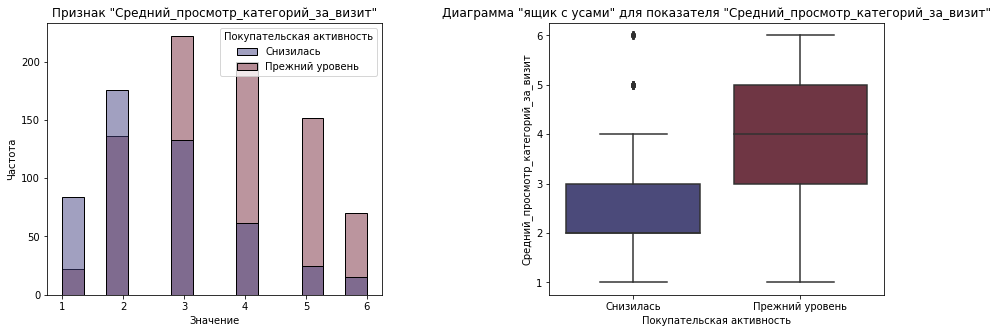

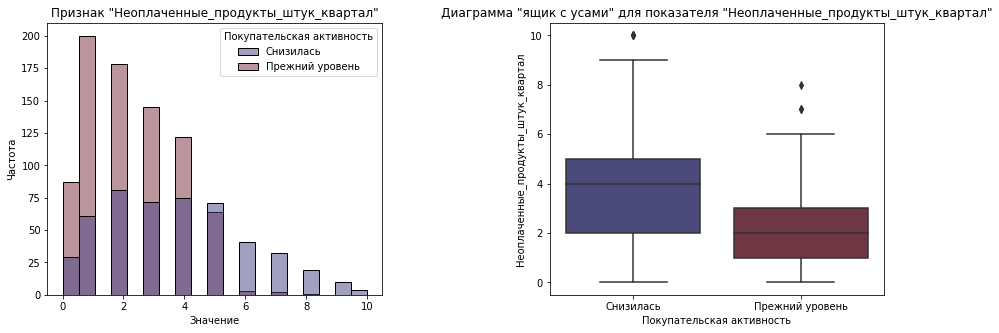

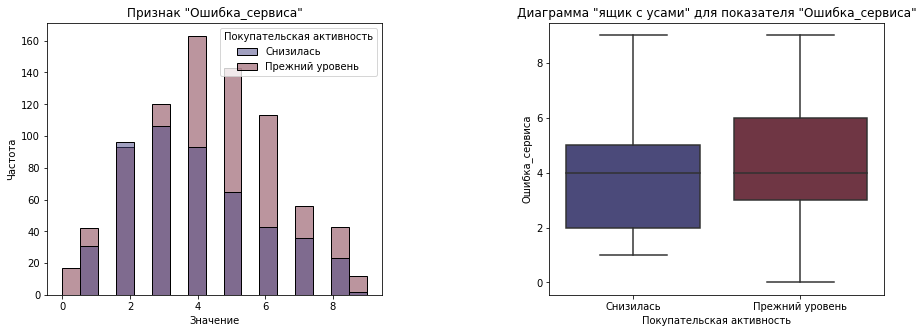

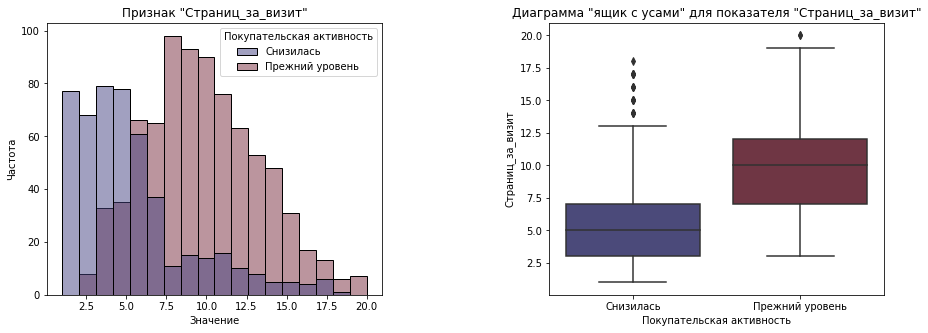

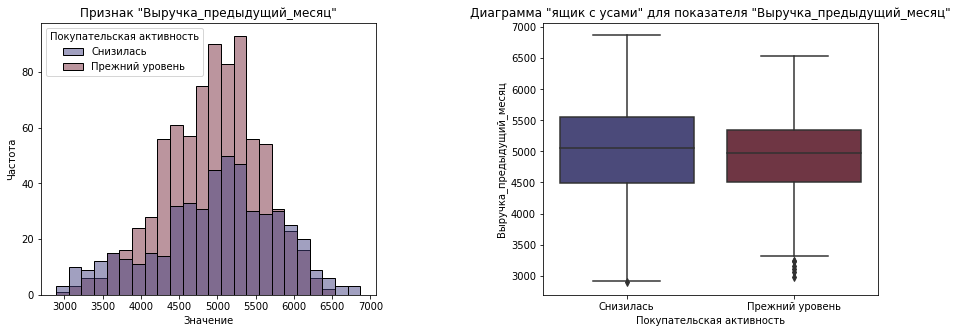

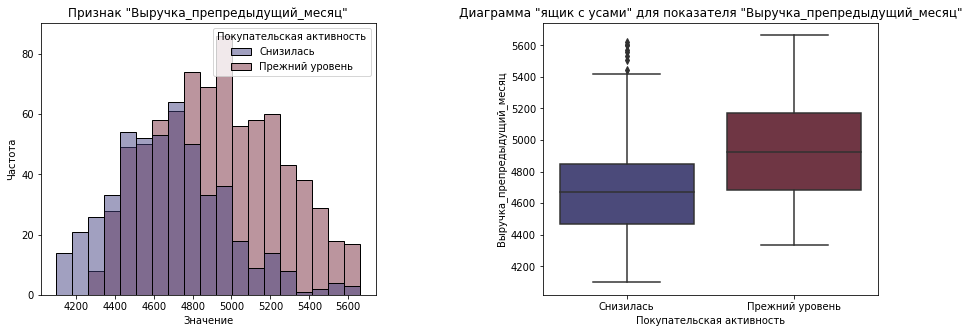

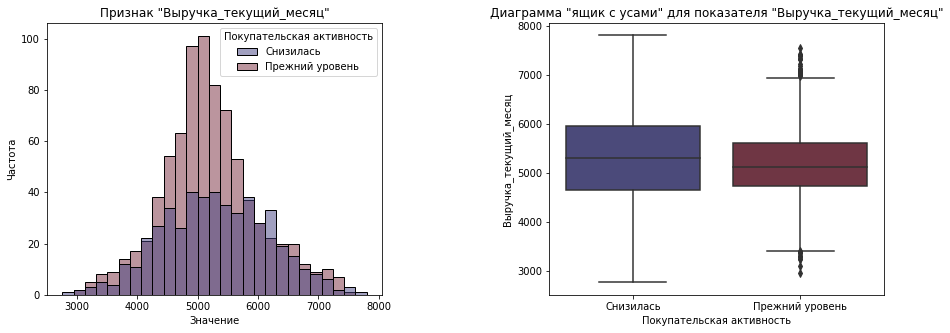

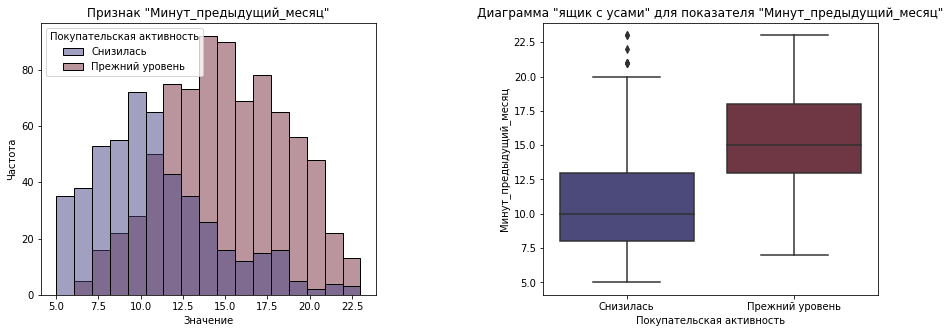

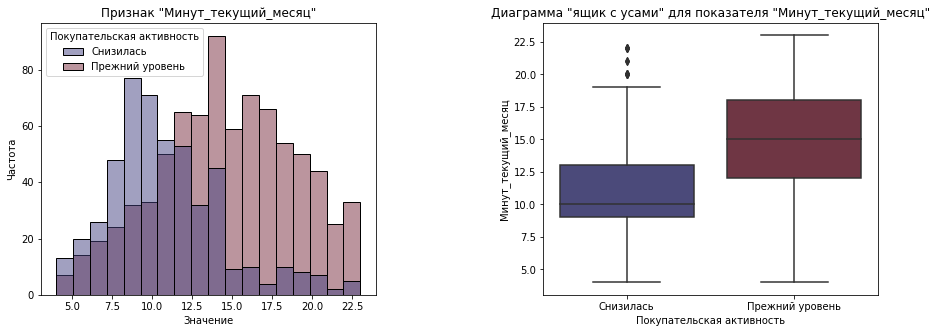

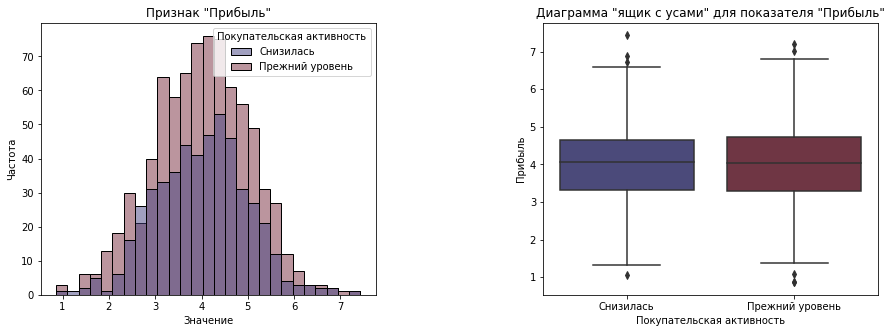

In [72]:
hist_box(market_profit, num_cols, 'Покупательская активность')

*Сравним категориальные признаки по покупательской активности*

In [73]:
#функция построения круговых диаграмм для качественных данных, где df – датафрейм 

def activity_cat(df):
    df_inactive = df[df['Покупательская активность'] == 'Снизилась'].drop('Покупательская активность', axis=1)
    df_active = df[df['Покупательская активность'] != 'Снизилась'].drop('Покупательская активность', axis=1)
    cat_cols = list(df_inactive.select_dtypes(exclude='number').columns)
    for col in cat_cols:
        labels = list(df[col].value_counts().index)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.pie(df_inactive[col].value_counts(), labels=labels, autopct='%1.1f%%')
        plt.xlabel('Покупательская активность снизилась')

        plt.subplot(1, 2, 2)
        plt.pie(df_active[col].value_counts(), labels=labels, autopct='%1.1f%%')
        plt.xlabel('Покупательская активность прежняя')
        plt.subplots_adjust(wspace=0.5, hspace=0.8)
        plt.suptitle(f'Круговая диаграмма признака "{col}"', y=0.8)
        plt.show()

In [74]:
market_profit.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль,Вероятность снижения покупательской активности
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16,1.00
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13,0.33
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87,1.00
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21,1.00
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95,0.67


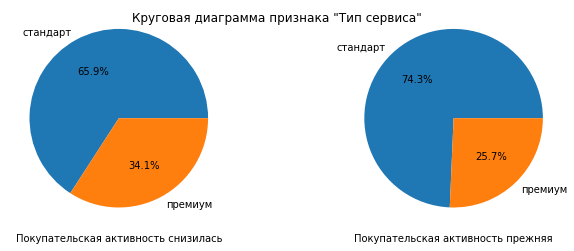

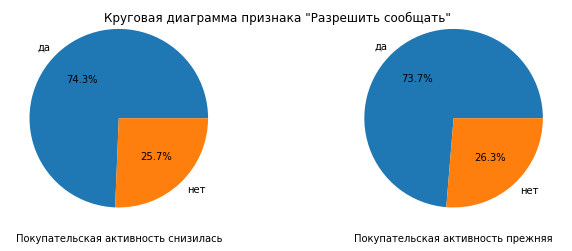

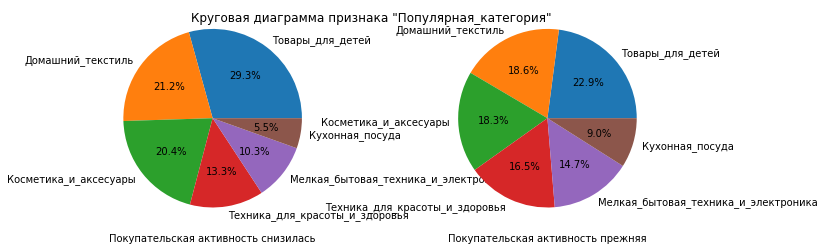

In [75]:
activity_cat(market_profit)

*По круговым диаграммам видно, что в большей степени покупательская активность снизилась среди пользователей, ищущих товары для детей (29,3% против 22,9%). Также отмечается бОльшая доля пользователей с премиумом, среди тех у кого покупательская активность снизилась 34,1% против 25,7%*

*Посмотрим на группу покупателей с большой долей акционных покупок. Данный сегмент был выбран, потому что количество акционных покупок является одним из наиболее важных прогностических признаков снижения активности пользователей*

In [76]:
promo_lovers = market_profit[market_profit['Акционные_покупки'] >=0.7]

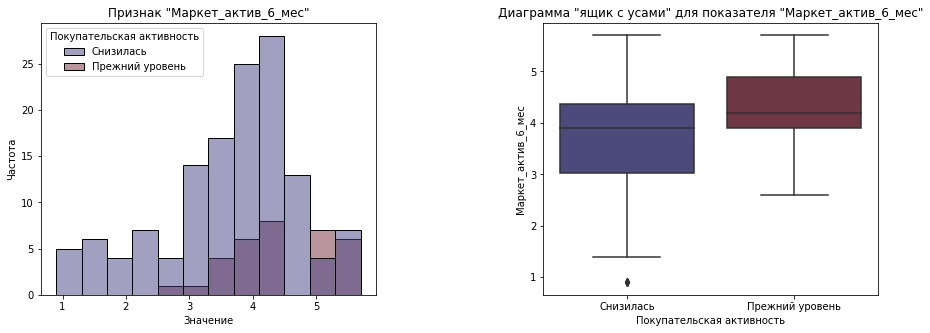

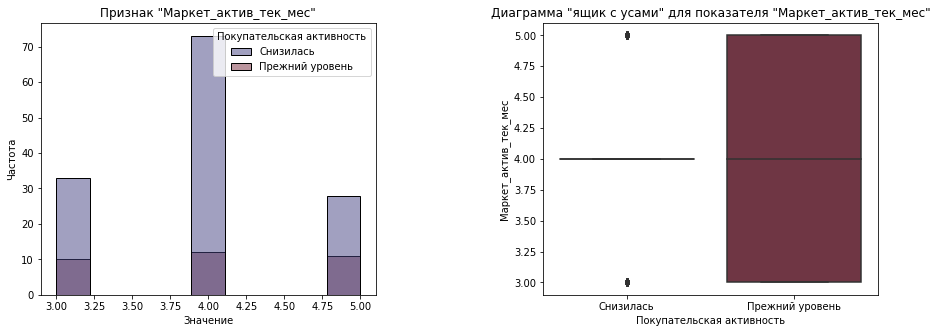

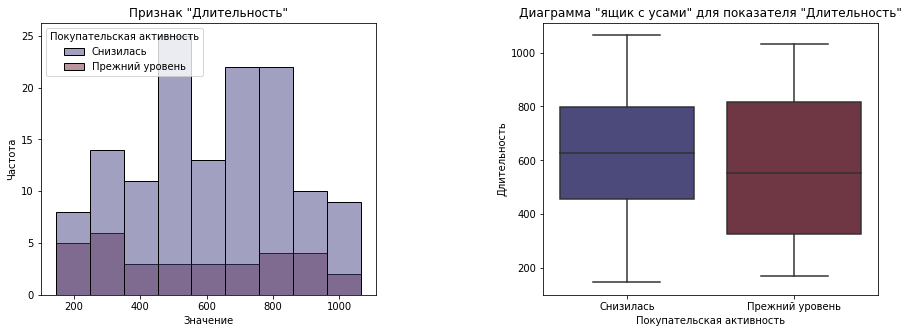

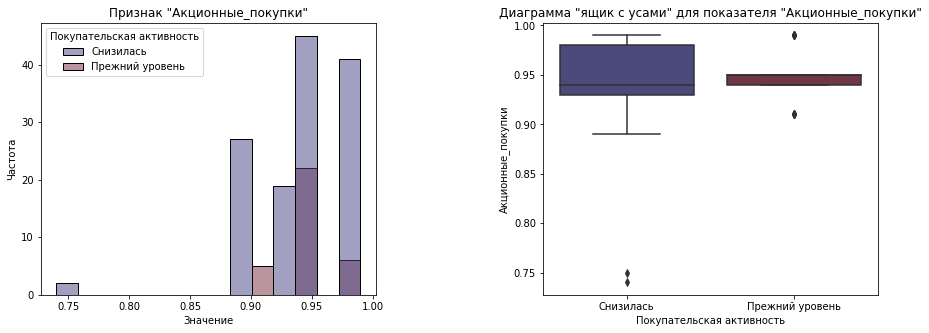

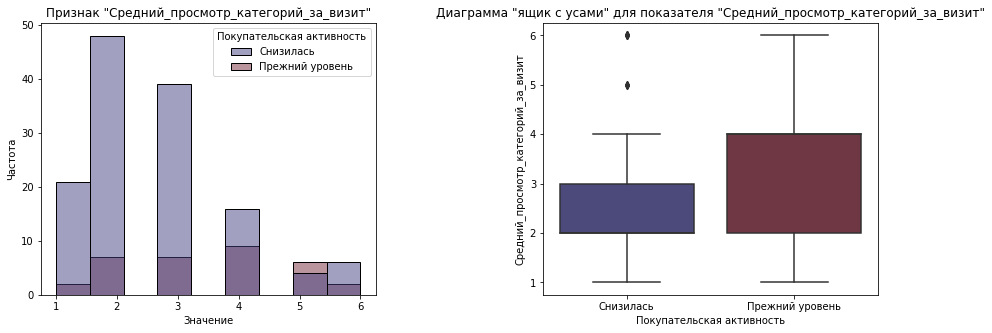

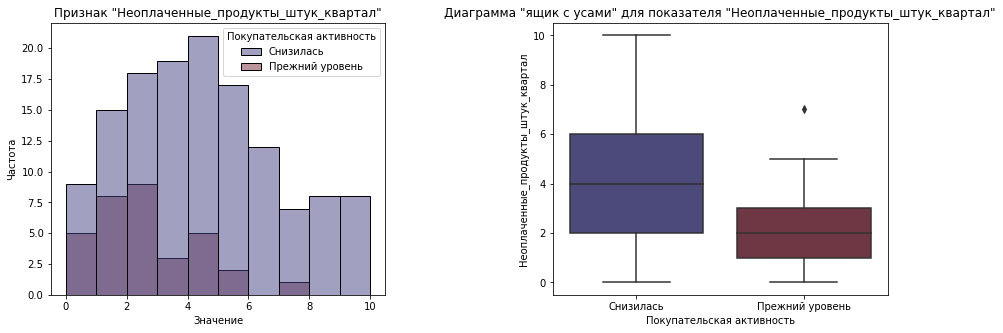

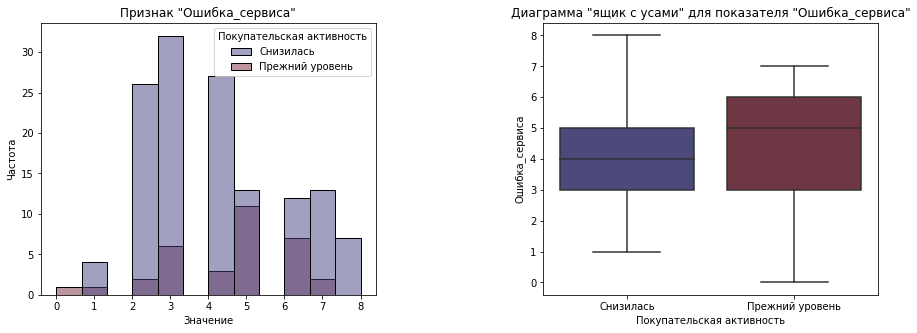

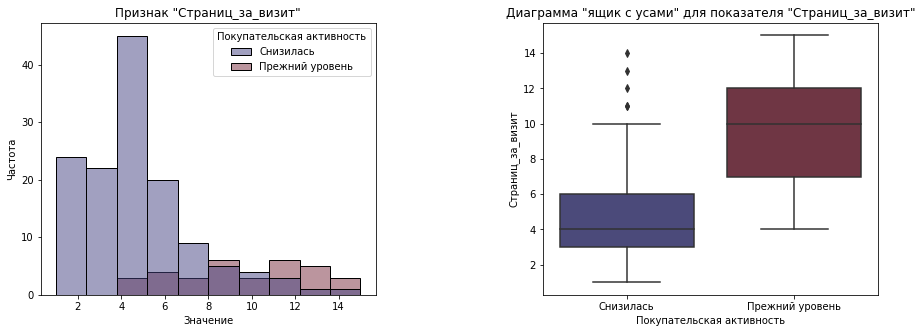

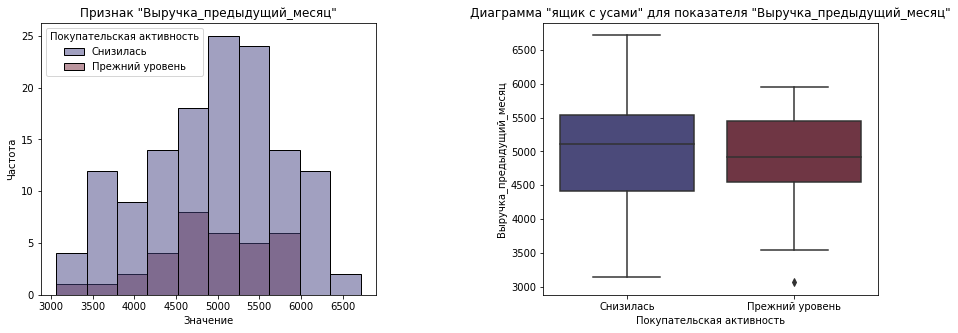

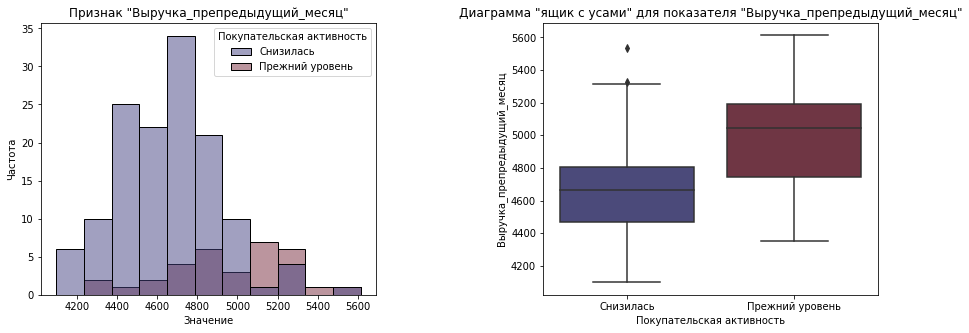

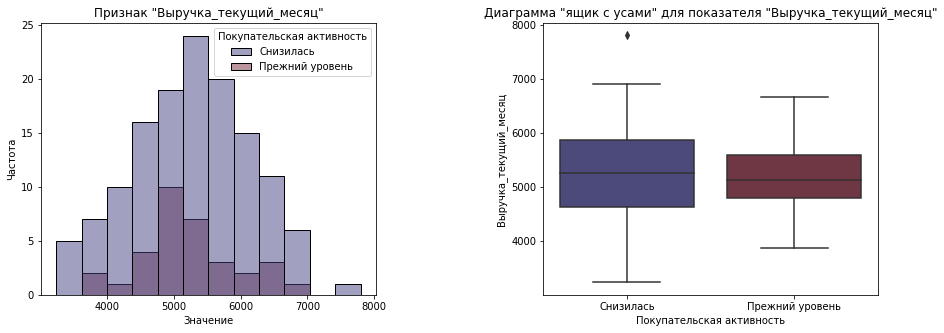

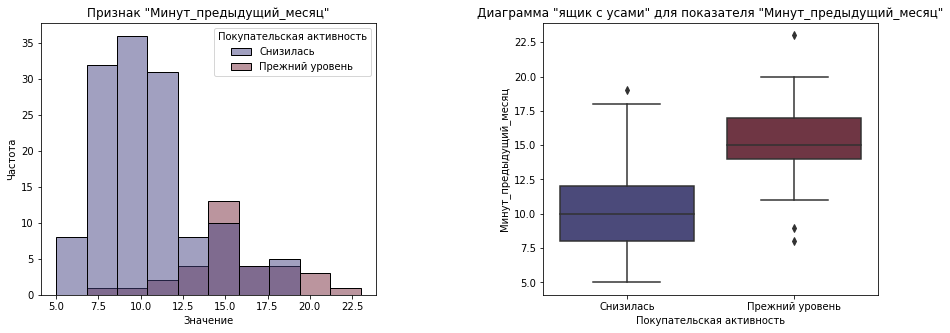

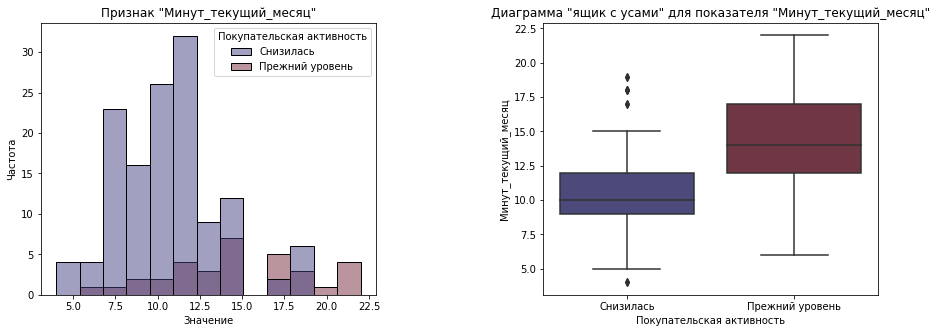

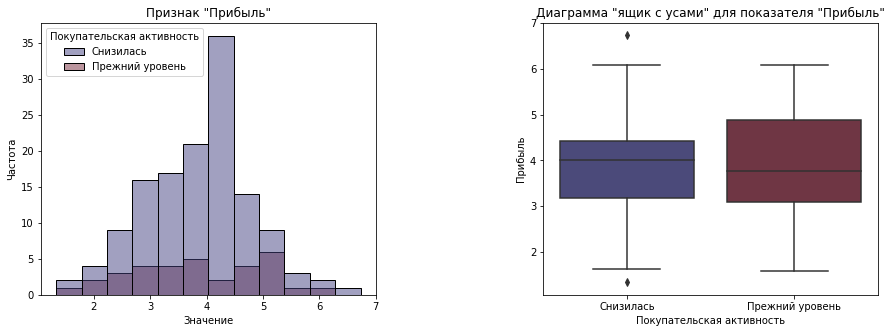

In [77]:
hist_box(promo_lovers, num_cols, 'Покупательская активность')

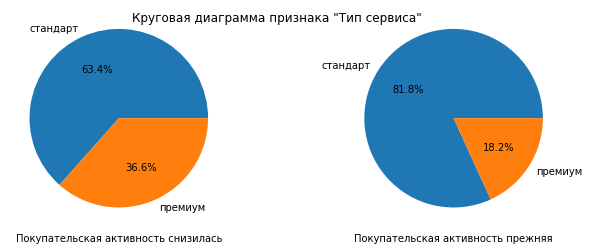

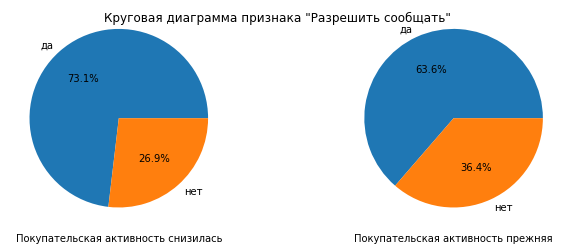

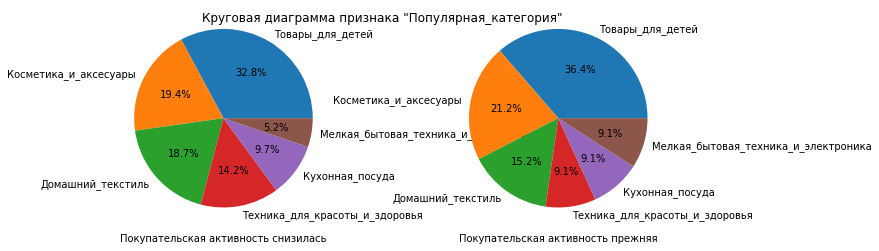

In [78]:
activity_cat(promo_lovers)

#### Выводы по шагу 8
*Несколько выводов по категории пользователей с большой долей акционных покупок:*

1. Прибыль (и выручка за предыдущий месяц и текущий месяц) от них не снизилась, независимо от покупательской активности.
2. У акционных пользователей со сниженной активностью была меньшая выручка за позапрошлый месяц (4700 против 5100). Возможно, 3 месяца назад проводились акции, за счет которых пользователи сэкономили и принесли меньше денег бизнесу. Либо, наоборот, акции стали проводить в предыдущем и текущем месяце и выручка от их покупок увеличилась. Здесь зависит от экономических особенностей акций. Первый вариант видится более вероятным, т.к. пользователи со снизившейся активностью проводили меньше минут в прошлом и текущем месяце на сайте - возможно, за позапрошлый месяц они могли дольше задержаться на сайте и купить больше товаров. 
3. Маркетинговые контакты за последние 6 мес. не сильно повлияли на их активность (в среднем, чуть меньше 4 контактов при сниженной активности, около 4-5  – при сохранившейся). Однако при количестве контактов менее 3-4 за полгода шансов на сохрание покупательской активности не остается. 
4. Длительность с момента регистрации на сайте мало влияет на активность акционных покупателей.
5. Акционные пользователи со снизившейся активностью просматривают не более 3 категорий за визит, и число страниц просмотра меньше (4 против 10). 
6. У акционных пользователей со сниженной активностью больше неоплаченных товаров за квартал – 4 шт. против 2 шт. Возможно, они отложили товары в корзину на случай будущих распродаж, чтобы долго их не искать. Либо просматривали товары, откладывали в корзину, но так и не решились купить из-за не устраивающей их цены.
7. Среди акционных пользователей со сниженной активностью выделяется в 2 раза бОльшая доля людей с премиумом. Возможно, премиум дает больше преимуществ на распродажах, и это послужило стимулом приобретения премиума. Однако в остальное время премиум не несет для такой категории сильных преимуществ. По категории товаров акционные пользователи сходны, за исключением того, что пользователи с прежней активностью немного чаще покупают мелкую бытовую технику и электронику и меньше - технику для красоты и здоровья. 

***Рекомендации для магазина по увеличению покупательской активности для пользователей с большой долей акционных покупок на основании выводов выше***:

1. Продолжать проводит не менее 4 контактов за полгода, чтобы поддержать активность.
2. Рассмотреть возможность проведения акций на товары, отложенные в корзине.
3. Усилить систему рекомендаций и, возможно, ввести акции за покупку нескольких товаров из смежных категорий.
4. Пересмотреть особенности премиума. Возможно, чаще проводить закрытые распродажи для людей с премиумом, делать больше предложений на мелкую бытовую технику и электронику.
5. Чаще проводить распродажи. 

# Шаг 9. Общий вывод
Сделайте общий вывод:

    опишите задачу;
    опишите исходные данные и проведённую предобработку;
    напишите, что вы сделали для поиска лучшей модели;
    укажите лучшую модель;
    добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.

1. Описание задачи:
    * Построить модель предсказания покупательской активности покупателей и на ее основе выделить сегменты покупателей для персонализации предложений
2. Описание исходных данных и проведенной предобработки:
    * Были предоставлены 4 датасета с 1300 уникальными пользователями.
    * Явных дубликатов не обнаружено. Исправлены орфографически ошибки в некоторых столбцах с категориальными признаками.
    * Пропусков не обнаружено.
3. Шаги по поиску лучшей модели:
    * Проведен анализ мультиколлинеарности признаков по методу `phik`. Явной мультиколлинеарности $(phik≥0.9)$ не обнаружено. По методу `VIF` были обнаружены признаки с высокой корреляцией с другими входными признаками $(VIF≥10)$, однако из модификация (в виде арифметического среднего) и удаление из выборки не повысило точность модели по методу `ROC-AUC`, поэтому в модель был передан весь датасет без удаления и модификации признаков.
    * Создан сложный пайплайн для подбора лучшей модели и гиперпараметров.
4. Лучшая модель – `KNeighborsClassifier(n_neighbors=6)`.
5. Наиболее важные прогностические признаки модели – `Страниц_за_визит`, `Мин_предыдущий_месяц`, `Мин_текущий_месяц`, `Акционные_покупки`
6. В качестве сегмента покупателей были отобраны покупатели с высокой долей акционных покупок, т.к. этот признак существенно влияет на результат предсказания модели. Общие рекомендации по сохранению покупательской активности: не менее 4 маркетинговых контактов за полгода, акции на товары в корзине, чаще проводить распродажи (особенно для премиума), усилить систему рекомендаций.